# Intro to Raster data
We will first be using the rasterio package to load and deal with raster data


In [5]:
# need to specify location of some certificates for rasterio
!export CURL_CA_BUNDLE=/etc/ssl/certs/ca-certificates.crt
try:
  import rasterio
  import rasterio.plot
  import rasterio.merge 
  import rasterio.mask
except:
  !pip install rasterio
  import rasterio
  import rasterio.plot
  import rasterio.merge
  import rasterio.mask
  
try:
  import rasterstats as rs
except:
  !pip install rasterstats  
  import rasterstats as rs
  
try:
  !conda
  import pyproj
except:
  !pip install pyproj
  import pyproj
  
import networkx as nx
try:
  import osmnx as ox
except:
  # osmnx depends on the system package libspatialindex
  !apt install libspatialindex-dev
  !pip install osmnx
  import osmnx as ox

try: 
  import geopandas as gpd
except: 
  !pip install geopandas 
  import geopandas as gpd
  
try:
  import contextily as ctx 
except:
  # install dependencies for contextily
  !apt install libproj-dev proj-data proj-bin
  !apt install libgeos-dev
  !pip install cython
  !pip install cartopy
  # install contextily
  !pip install contextily==1.0rc1 --no-use-pep517 --no-cache-dir
  import contextily as ctx
  
import fiona
from shapely.geometry import Point, LineString, Polygon
  
import gdal
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

usage: conda [-h] [-V] command ...

conda is a tool for managing and deploying applications, environments and packages.

Options:

positional arguments:
  command
    clean        Remove unused packages and caches.
    config       Modify configuration values in .condarc. This is modeled
                 after the git config command. Writes to the user .condarc
                 file (/home/jovyan/.condarc) by default.
    create       Create a new conda environment from a list of specified
                 packages.
    help         Displays a list of available conda commands and their help
                 strings.
    info         Display information about current conda install.
    init         Initialize conda for shell interaction. [Experimental]
    install      Installs a list of packages into a specified conda
                 environment.
    list         List linked packages in a conda environment.
    package      Low-level conda package utility. (EXPERIMENTAL)
    remove   

## Getting topological raster data
We're going to use a Digital Elevation Model from USGS. 

You can search for data products from USGS [here](https://viewer.nationalmap.gov/basic/#productGroupSearch). We are using elevation products (3DEP) at 1/3 arc-second (~10m) resolution. Each tile spans 1x1 degree.

The files are available as .zip of [Erdas Imagine .img](https://gdal.org/drivers/raster/hfa.html) filetypes. You can get the files using the rasterio `zip+https://` [syntax](https://rasterio.readthedocs.io/en/stable/topics/datasets.html) to get the unzipped .img files from the url.

These files are quite large (~900 MB per tile). To reduce download time, I have already downloaded these files and put them in the course folder. If you are interested in how you would download these files yourself, uncomment the following cell.

In [6]:
# # Get raster of boston-area elevations (takes a while)
# tile1_url = 'zip+https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/IMG/USGS_NED_13_n43w072_IMG.zip!USGS_NED_13_n43w072_IMG.img'
# tile2_url = 'zip+https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/IMG/USGS_NED_13_n43w071_IMG.zip!USGS_NED_13_n43w071_IMG.img'

# # we'll write them to local files so we don't have to keep downloading
# local_tile1_location = 'local_tile1.tif'
# local_tile2_location = 'local_tile2.tif'

# def download_to_local(tile_url, local_tile_path):
#   with rasterio.Env():
#     with rasterio.open(tile_url) as src:
#       profile = src.profile
#       profile['dtype'] = 'float64'
#       profile['indexes'] = 1
#       print(profile)
#       with rasterio.open(local_tile_path, 'w', **profile) as dst:
#         dst.write_band(1,src.read(1).squeeze().astype(np.float64))
      
# download_to_local(tile1_url, local_tile1_location)
# download_to_local(tile2_url, local_tile2_location)

We'll use the preloaded copy so we don't have to all download it

In [7]:
local_tile1_location = '/home/jovyan/course/05-satellite/dem/local_tile1.img'
local_tile2_location = '/home/jovyan/course/05-satellite/dem/local_tile2.img'

In [8]:
# the files are really big, so we'll open them at lower resolution each
rescaling_factor = 0.25
with rasterio.open(local_tile1_location) as src:
  print(src.profile)
  new_height = int(src.height*rescaling_factor)
  new_width = int(src.width*rescaling_factor)
  tile1 = src.read(1, out_shape=(new_height, new_width), 
                   resampling=rasterio.enums.Resampling.bilinear)
  tile1_profile = src.profile
  tile1_profile['transform'] = src.transform * src.transform.scale((src.width/tile1.shape[-1]),
                                                        (src.height/tile1.shape[-2]))
  tile1_profile['height'] = new_height
  tile1_profile['width'] = new_width
  
  
with rasterio.open(local_tile2_location) as src:
  print(src.profile)
  tile2 = src.read(1, out_shape=(int(src.height*rescaling_factor), 
                                 int(src.width*rescaling_factor)), 
                   resampling=rasterio.enums.Resampling.bilinear)
  tile2_profile = src.profile
  tile2_profile['transform'] = src.transform * src.transform.scale((src.width/tile2.shape[-1]),
                                                        (src.height/tile2.shape[-2]))
  tile2_profile['height'] = new_height
  tile2_profile['width'] = new_width

{'driver': 'HFA', 'dtype': 'float64', 'nodata': -3.4028234663853e+38, 'width': 10812, 'height': 10812, 'count': 1, 'crs': CRS.from_epsg(4269), 'transform': Affine(9.259259252584582e-05, 0.0, -72.00055555519407,
       0.0, -9.259259252584582e-05, 43.00055555489587), 'blockxsize': 64, 'blockysize': 64, 'tiled': True}
{'driver': 'HFA', 'dtype': 'float64', 'nodata': -3.4028234663853e+38, 'width': 10812, 'height': 10812, 'count': 1, 'crs': CRS.from_epsg(4269), 'transform': Affine(9.259259252584581e-05, 0.0, -71.00055555539387,
       0.0, -9.259259252584581e-05, 43.00055555489587), 'blockxsize': 64, 'blockysize': 64, 'tiled': True}


Now let's also save the low res versions to file for ease of reference. We'll also use the GeoTiff format instead of img

In [9]:
tile1_profile['driver'] = 'GTiff'
tile2_profile['driver'] = 'GTiff'
lowres_tile1_loc = 'lowres_tile1.tif'
lowres_tile2_loc = 'lowres_tile2.tif'
with rasterio.open(lowres_tile1_loc, 'w', **tile1_profile) as outfile:
  outfile.write(tile1, 1)
with rasterio.open(lowres_tile2_loc, 'w', **tile2_profile) as outfile:
  outfile.write(tile2, 1)

In [10]:
print(tile1.shape, tile2.shape)

(2703, 2703) (2703, 2703)


**Now let's visualize**

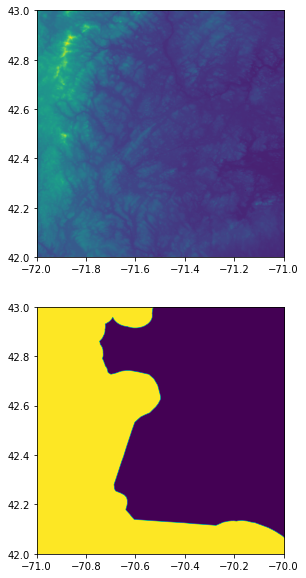

In [11]:
fig = plt.figure(figsize=[10,10])
ax1 = fig.add_subplot(2,1,1)
rasterio.plot.show(tile1, ax=ax1, transform=tile1_profile['transform'])
ax2 = fig.add_subplot(2,1,2)
rasterio.plot.show(tile2, ax=ax2, transform=tile2_profile['transform'])


The second part looks weird, right? That's because it contains `nodata` values, which are `-3.4028234663853e+38`. That makes the low end way too low. 

Fortunately, there's a masking function that lest us select all of the non-nodata pixels

In [12]:
with rasterio.open(lowres_tile1_loc) as src:
  tile1_mask = src.read_masks(1)

with rasterio.open(lowres_tile2_loc) as src:
  tile2_mask = src.read_masks(1)


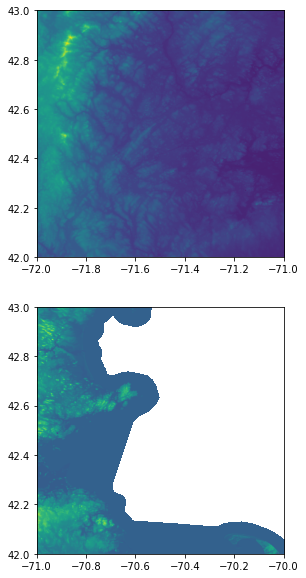

In [13]:
# we use the np.ma.masked_where() function to mask out all the values equal to zero
fig = plt.figure(figsize=[10,10])
ax1 = fig.add_subplot(2,1,1)
rasterio.plot.show(np.ma.masked_where(tile1_mask==0, tile1), ax=ax1, transform=tile1_profile['transform'])
ax2 = fig.add_subplot(2,1,2)
rasterio.plot.show(np.ma.masked_where(tile2_mask==0, tile2), ax=ax2, transform=tile2_profile['transform'])

Let's combine the two tiles together into one large mosaic and save it as a geotiff

In [14]:
combined_location = 'combined.tif'

In [15]:
with rasterio.open(lowres_tile1_loc, 'r') as src1:
  with rasterio.open(lowres_tile2_loc, 'r') as src2:
    combined, out_transform = rasterio.merge.merge([src1, src2],
                                                   nodata=src2.profile['nodata'])
    combined_meta = src1.profile.copy()
    combined_meta.update({'driver':'GTiff',
                     'count': combined.shape[0],
                    'height': combined.shape[1],
                    'width': combined.shape[2],
                    'transform': out_transform,
                    'crs': src1.crs})
    with rasterio.open(combined_location, 'w', **combined_meta) as dst:
      dst.write(combined)


{'driver': 'GTiff', 'dtype': 'float64', 'nodata': -3.4028234663853e+38, 'width': 5404, 'height': 2703, 'count': 1, 'crs': CRS.from_epsg(4269), 'transform': Affine(0.0003703703701033833, 0.0, -72.00055555519407,
       0.0, -0.0003703703701033833, 43.00055555489587)}


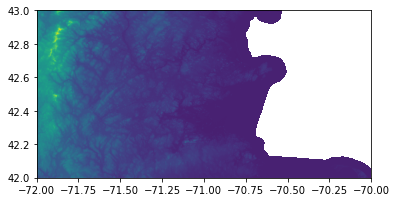

In [16]:
with rasterio.open(combined_location, 'r') as src:
  print(src.meta)
  combined = src.read(1)
  combined_mask = src.read_masks(1)
  combined_transform = src.profile['transform']
  rasterio.plot.show(np.ma.masked_where(combined_mask==0, combined), 
                     transform=combined_transform)

Let's take a look at what cambridge and boston look like on this map

In [17]:
camb_name = "Cambridge, MA, USA"
graph_area_cambridge = ox.gdf_from_place(camb_name)
bos_name = "Boston, MA, USA"
graph_area_bos = ox.gdf_from_place(bos_name)
local_areas = graph_area_bos.append(graph_area_cambridge, ignore_index=True)

# Save to local shapefile
!mkdir -p local_areas
local_areas.to_crs(epsg=4269).to_file('local_areas/local_areas.shp')

In [18]:
local_areas

,geometry,place_name,bbox_north,bbox_south,bbox_east,bbox_west
0,"POLYGON ((-71.19125 42.28299, -71.19123 42.282...","Boston, Suffolk County, Massachusetts, United ...",42.396977,42.227911,-70.804488,-71.191249
1,"POLYGON ((-71.16040 42.38654, -71.15814 42.383...","Cambridge, Middlesex County, Massachusetts, Un...",42.404259,42.352402,-71.063984,-71.160399


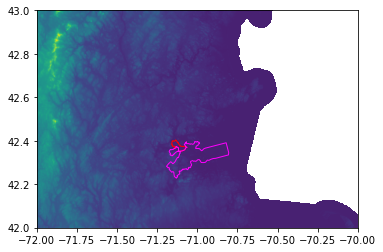

In [20]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
p = rasterio.plot.show(np.ma.masked_where(combined_mask==0, combined), 
                       ax=ax, transform=combined_transform)
graph_area_cambridge.to_crs(epsg=4269).plot(ax=ax, facecolor='none', edgecolor='red')
graph_area_bos.to_crs(epsg=4269).plot(ax=ax, facecolor='none', edgecolor='magenta')
plt.show()

We can [crop the raster using these vectors](https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html)

In [21]:
with rasterio.open(combined_location, 'r') as src:
  out_image, out_transform = rasterio.mask.mask(src, local_areas['geometry'].values, crop=True)
  out_profile = src.profile
  out_profile.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
with rasterio.open("masked_elevation_local.tif", "w", **out_profile) as masked_outfile:
  masked_outfile.write(out_image)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': -3.4028234663853e+38, 'width': 1045, 'height': 477, 'count': 1, 'crs': CRS.from_epsg(4269), 'transform': Affine(0.0003703703701033833, 0.0, -71.19129629651817,
       0.0, -0.0003703703701033833, 42.40425925902942)}


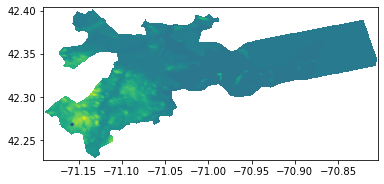

In [22]:
with rasterio.open('masked_elevation_local.tif', 'r') as src:
  print(src.meta)
  local_crop = src.read(1)
  local_crop_mask = src.read_masks(1)
  local_transform = src.profile['transform']
  rasterio.plot.show(np.ma.masked_where(local_crop_mask==0, local_crop), 
                     transform=local_transform)

There's a library called `rasterstats` https://pythonhosted.org/rasterstats/index.html which allows you to compute basic statistics on raster data using shapefiles to group

In [23]:
rs.zonal_stats('local_areas/local_areas.shp','combined.tif',stats='min mean max')

[{'min': -69.63871765136719,
  'max': 100.14869689941406,
  'mean': 9.451499857453971},
 {'min': 0.14903046190738678,
  'max': 23.76325225830078,
  'mean': 4.891143955819088}]

# GDAL
Another package that's very useful for processing raster is GDAL, which is used behind the scenes for a lot of GIS applications. https://gdal.org/index.html

In this example, we'll be using it to create a hillshade. GDAL is available as a set of command line tools, which are installed in `/opt/conda/bin/`
In particular, we're using `gdaldem` which is the gdal tool for working with digital elevation models.

In [24]:
!/opt/conda/bin/gdaldem hillshade combined.tif hs.tif

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
0...10...20...30...40...50...60...70...80...90...100 - done.


{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 5404, 'height': 2703, 'count': 1, 'crs': CRS.from_epsg(4269), 'transform': Affine(0.0003703703701033833, 0.0, -72.00055555519407,
       0.0, -0.0003703703701033833, 43.00055555489587)}


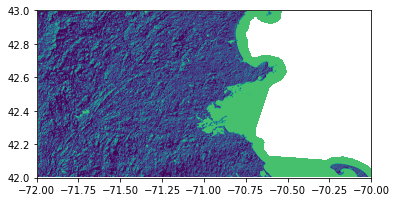

In [25]:
with rasterio.open('hs.tif', 'r') as src:
  print(src.meta)
  hillshade = src.read(1)
  hillshade_mask = src.read_masks(1)
  hillshade_transform = src.profile['transform']
  rasterio.plot.show(np.ma.masked_where(hillshade_mask==0, hillshade), 
                     transform=hillshade_transform)

In [27]:
!/opt/conda/bin/gdaldem slope combined.tif slope.tif

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
0...10...20...30...40...50...60...70...80...90...100 - done.


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 5404, 'height': 2703, 'count': 1, 'crs': CRS.from_epsg(4269), 'transform': Affine(0.0003703703701033833, 0.0, -72.00055555519407,
       0.0, -0.0003703703701033833, 43.00055555489587)}


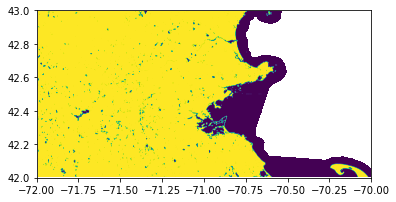

In [28]:
with rasterio.open('slope.tif', 'r') as src:
  print(src.meta)
  hillshade = src.read(1)
  hillshade_mask = src.read_masks(1)
  hillshade_transform = src.profile['transform']
  rasterio.plot.show(np.ma.masked_where(hillshade_mask==0, hillshade), 
                     transform=hillshade_transform)

In [148]:
lowell_name = "Lowell, MA, USA"
springfield_name = "Springfield, MA, USA"
salem_name = "Salem, MA, USA"
worcester_name = "Worcester, MA, USA"
#graph_area_lowell = ox.gdf_from_place(lowell_name)
#graph_area_springfield = ox.gdf_from_place(springfield_name)
#graph_area_salem = ox.gdf_from_place(salem_name)
graph_area_worcester = ox.gdf_from_place(worcester_name)
#local_areas = local_areas.append(graph_area_lowell, ignore_index=True)
#local_areas = local_areas.append(graph_area_springfield, ignore_index=True)
#local_areas = local_areas.append(graph_area_salem, ignore_index=True)
local_areas = local_areas.append(graph_area_worcester, ignore_index=True)
# Save to local shapefile
!mkdir -p local_areas
local_areas.to_crs(epsg=4269).to_file('local_areas/local_areas.shp')

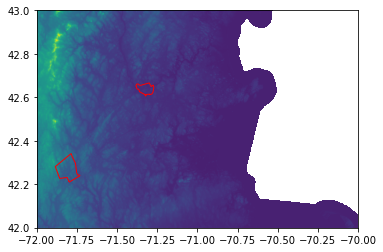

In [155]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
p = rasterio.plot.show(np.ma.masked_where(combined_mask==0, combined), 
                       ax=ax, transform=combined_transform)
graph_area_lowell.to_crs(epsg=4269).plot(ax=ax, facecolor='none', edgecolor='red')
graph_area_worcester.to_crs(epsg=4269).plot(ax=ax, facecolor='none', edgecolor='red')
#graph_area_springfield.to_crs(epsg=4269).plot(ax=ax, facecolor='none', edgecolor='red')
#graph_area_salem.to_crs(epsg=4269).plot(ax=ax, facecolor='none', edgecolor='red')
plt.show()

In [150]:
with rasterio.open(combined_location, 'r') as src:
  out_image, out_transform = rasterio.mask.mask(src, local_areas['geometry'].values, crop=True)
  out_profile = src.profile
  out_profile.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
with rasterio.open("masked_elevation_local.tif", "w", **out_profile) as masked_outfile:
  masked_outfile.write(out_image)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': -3.4028234663853e+38, 'width': 2916, 'height': 1234, 'count': 1, 'crs': CRS.from_epsg(4269), 'transform': Affine(0.0003703703701033833, 0.0, -71.8842592589816,
       0.0, -0.0003703703701033833, 42.66685185143272)}


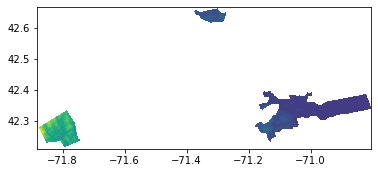

In [151]:
with rasterio.open('masked_elevation_local.tif', 'r') as src:
  print(src.meta)
  local_crop = src.read(1)
  local_crop_mask = src.read_masks(1)
  local_transform = src.profile['transform']
  rasterio.plot.show(np.ma.masked_where(local_crop_mask==0, local_crop), 
                     transform=local_transform)

In [152]:
rs.zonal_stats('local_areas/local_areas.shp','combined.tif',stats='min mean max range')

[{'min': -69.63871765136719,
  'max': 100.14869689941406,
  'mean': 9.451499857453971,
  'range': 169.78741455078125},
 {'min': 0.14903046190738678,
  'max': 23.76325225830078,
  'mean': 4.891143955819088,
  'range': 23.614221796393394},
 {'min': 13.702727317810059,
  'max': 92.91802978515625,
  'mean': 38.04751764578777,
  'range': 79.21530246734619},
 {'min': 108.41999816894531,
  'max': 320.5447998046875,
  'mean': 179.34516405814256,
  'range': 212.1248016357422}]

In [153]:
local_areas

,geometry,place_name,bbox_north,bbox_south,bbox_east,bbox_west
0,"POLYGON ((-71.19125 42.28299, -71.19123 42.282...","Boston, Suffolk County, Massachusetts, United ...",42.396977,42.227911,-70.804488,-71.191249
1,"POLYGON ((-71.16040 42.38654, -71.15814 42.383...","Cambridge, Middlesex County, Massachusetts, Un...",42.404259,42.352402,-71.063984,-71.160399
2,"POLYGON ((-71.38248 42.65256, -71.38240 42.652...","Lowell, Middlesex County, Massachusetts, Unite...",42.666516,42.606494,-71.271188,-71.382479
3,"POLYGON ((-71.88404 42.28125, -71.85663 42.226...","Worcester, Worcester County, Massachusetts, Un...",42.341187,42.210040,-71.731237,-71.884043


In [154]:
np.max(np.ma.masked_where(local_crop_mask==0, local_crop).data)

320.5447998046875

In [146]:
local_areas = local_areas.drop(index = [4])